# Solving the 1D convection equation

## The example

This example presents code to reproduce Example 5.2 from the Moin textbook

The PDE of interest is

<br>
$$\frac{\partial u}{\partial t} +c\frac{\partial u}{\partial x} = 0 \quad \text{for}\quad x\in[0, \infty], \quad t\ge 0$$
<br>

Initial condition:
$$u(x, 0) = e^{-200(x-0.25)^2}$$

Boundary condition:
$$u(0, t) = 0$$
<br>

The central difference method is used to approximate the spatial derivative at all nodes without a Dirichlet condition:

<br>
$$\frac{du_j}{dt} = \frac{-c}{2\Delta x}(u_{j+1} - u_{j-1}) = \beta(u_{j+1} - u_{j-1}), \quad j = 1, 2, ..., N$$
<br>

where the constant $\beta = \dfrac{-c}{2\Delta x}$

At the boundary node at $x = L$, we use the backward difference method in space, resulting in the equation:

<br>
$$\frac{du_N}{dt} = \frac{-c}{\Delta x}(u_N - u_{N-1}) = 2\beta(u_N - u_{N-1})$$
<br>

The right-end boundary condition allows the shape to pass smoothly out of the domain on the right hand side.

To implement RK4, it is helpful to write the ODE for each node in the form $\dfrac{d\mathbf{u}}{dt} = \mathbf{f}(\mathbf{u})$ where $\mathbf{u} = [u_0, u_1, u_2, ..., u_N]$.

Noting that $\dfrac{du_0}{dt} = 0$ due to the Dirichlet condition at $x=0$, we can write

<br>
$$
\frac{du_j}{dt} = f_j(\mathbf{u}) = \left\{
\begin{array}{ll}
      0 & j = 0 \\
      \beta (u_{j+1} - u_{j-1}) & j = 1, 2, ..., N-1\\
      2\beta (u_{j} - u_{j-1}) & j = N \\
\end{array}
\right.
$$
<br>

Once the ODE function $\mathbf{f}(\mathbf{u})$ is defined, RK4 can be easily implemented in Python: see code below

<b>Try running the code below.</b>
* Adjust $\Delta x$ or $\Delta t$. Do you observe the expected stability behavior for RK4?
* What happens if you modify the variable <code>uleft</code>?

## Code Implementation

CFL number for this simulation                        = 1.0
CFL max for RK4 on this semi-discretized formulation  = 2.83


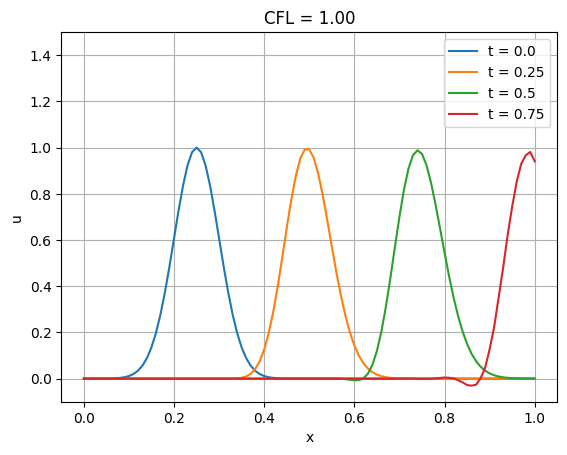

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Space discretization
L = 1                       # Spatial domain size
dx = 0.01                   # Spatial domain grid spacing
Nx = round(L/dx)            # Number of grid points = Nx + 1
x = np.linspace(0, L, Nx+1) # Array of grid points

# Time discretization
tend = 1                        # Ending time
dt = 0.01                       # Time step
Nt = round(tend/dt)             # Round to ensure integer
t = np.linspace(0, dt*Nt, Nt+1) # List of solution times

# Convection constant and beta
c = 1
beta = -c/(2*dx)

# Print critical RK4 time step info
CFL = c*(dt/dx)
print('CFL number for this simulation                        =', CFL)
print('CFL max for RK4 on this semi-discretized formulation  = 2.83')

# Boundary conditions
uleft = 0   # u(0) = 0

# Initial condition
uinit = np.exp(-200*(x-0.25)**2)

# Initialize solution variable
u = np.zeros((Nx+1, Nt+1))
u[:,0] = uinit

# Define the right-hand side function representing the system of ODEs
def fode(u):
    '''
    Assuming ODE du[j]/dt = f(u)[j], calculate f(u)[j] for j = 0, 1, 2, ..., Nx

    Input: u = u[:,n] where u[j,n] represents u(x[j], t[n])

    Return: f = [f0, f1, f2, ..., fN]
    '''

    # Initialize return vector
    f = np.zeros(len(u)) # [f0, f1, f2, ..., fN]

    # Loop on interior nodes
    for j in range(1, Nx):
        f[j] = beta*(u[j+1] - u[j-1])

    # Left and right end values
    f[0] = 0
    f[Nx] = 2*beta*(u[Nx] - u[Nx-1])

    return f


# Time loop
for n in range(Nt):

    # RK4 stages
    k1 = fode(u[:,n])
    k2 = fode(u[:,n] + 0.5*dt*k1)
    k3 = fode(u[:,n] + 0.5*dt*k2)
    k4 = fode(u[:,n] + dt*k3)

    # Solution update, non-Dirichlet nodes only
    u[1::,n+1] = u[1::,n] + dt/6*(k1[1::] + 2*k2[1::] + 2*k3[1::] + k4[1::])

    # Update the Dirichlet node at x = 0
    u[0,n+1] = uleft


"""
==================================================
Plotting code
==================================================
"""

# Plot of solution at several times
plt.figure()
tind = [0, round(0.25*Nt), round(0.5*Nt), round(0.75*Nt)]
for n in tind:
    plt.plot(x, u[:,n], label="t = "+str(t[n]))
plt.ylim([-0.1, 1.5])
plt.title(f'CFL = {CFL:.2f}')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.show()

# Animated plot

Below is code that will animate the solution for $u(x,t)$.

In [2]:
import plotly.graph_objects as go

# Base figure with initial data
fig = go.Figure(
    data=[go.Scatter(x=x, y=u[:, 0], mode="lines", line=dict(width=2), name="u(x,t)")],
    layout=go.Layout(
        width=700,    # figure width
        height=450,   # figure height
        title=f"Evolution of u Over Time (t = {t[0]:.2f})",
        xaxis=dict(title="Grid Points (x)", range=[np.min(x), np.max(x)]),
        yaxis=dict(title="Solution (u)", range=[-0.1, 1.5]),
        updatemenus=[{
            "type": "buttons",
            "buttons": [
                {
                    "label": "Play",
                    "method": "animate",
                    "args": [None, {"frame": {"duration": 50, "redraw": True},
                                    "fromcurrent": True,
                                    "transition": {"duration": 0}}],
                },
                {
                    "label": "Pause",
                    "method": "animate",
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                }
            ],
            "x": -0.2, "y": -0.15, "xanchor": "left", "yanchor": "top"
        }],
        sliders=[{
            "active": 0,
            "steps": [
                {
                    "args": [[str(j)], {"frame": {"duration": 0, "redraw": True},
                                        "mode": "immediate"}],
                    "label": f"{t[j]:.2f}",
                    "method": "animate"
                }
                for j in range(len(t))
            ],
            "x": 0.0, "y": -0.05, "xanchor": "left", "yanchor": "top",
            "len": 0.9
        }]
    ),
    frames=[
        go.Frame(
            data=[go.Scatter(x=x, y=u[:, j], mode="lines", line=dict(width=2))],
            name=str(j),
            layout=go.Layout(title=f"Evolution of u Over Time (t = {t[j]:.2f})")
        )
        for j in range(len(t))
    ]
)

fig.show()
